## Assignment-2: CNN to detect face mask or not?

In [19]:
# Using Google Colab paltform
# Using Google Drive to import datasets

from google.colab import drive

# mounting Google drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [20]:
# importing required libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

### 1. Load the images in appropriate data structures in your program, ready to be passed as input to the model for training. Consider input image size to be 64x64x3

In [21]:
batch_size = 32
img_height = 64
img_width = 64
epochs = 70

train_ds_path = '/content/gdrive/MyDrive/dataset-face-mask/dataset/train_validate'
test_ds_path = '/content/gdrive/MyDrive/dataset-face-mask/dataset/test'
validation_ds_path = '/content/gdrive/MyDrive/output/val'


In [22]:
# load the train and test datasets

def load_datasets(train_ds_path, test_ds_path):
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_ds_path, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
  test_ds =  tf.keras.preprocessing.image_dataset_from_directory(test_ds_path, seed=123, image_size=(img_height, img_width), batch_size=batch_size)
  return train_ds, test_ds

train_ds, test_ds =  load_datasets(train_ds_path, test_ds_path)

Found 1727 files belonging to 2 classes.
Found 320 files belonging to 2 classes.


In [23]:
# display the trained datasets class names

class_names = train_ds.class_names
print('Class names are ' + str(class_names))

Class names are ['masked', 'unmasked']


In [24]:
# Caching the train/test/validation dataset for prformance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [25]:
# Normalization the train datasets

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 

0.12168735 0.96614206


### 2. Configure the CNN model (use keras tensorflow), an indicative (minimal) configuration is as below. Take activation function (A)=relu. 
Feel free to use standard values for anything that is not mentioned (eg, take pool size 2x2, filter size 3x3, and so on)
No of the datasets classes are 2

In [26]:
num_classes = 2
default_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='softmax'),
  layers.Dense(num_classes)
])

# Compile the model with adam optimizer with metrics as accuracy
default_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

### 3. Train the CNN model for E epoch (take E=70), save the train_loss, train_acc, validation_loss, validation_acc for each epoch and plot it after training has finished. [4 points]

In [27]:
default_model_saved = default_model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/70
54/54 [==============================] - 6s 105ms/step - loss: 0.6709 - accuracy: 0.5933 - val_loss: 0.6340 - val_accuracy: 0.7531
Epoch 2/70
54/54 [==============================] - 5s 84ms/step - loss: 0.5778 - accuracy: 0.9227 - val_loss: 0.6854 - val_accuracy: 0.5375
Epoch 3/70
54/54 [==============================] - 5s 84ms/step - loss: 0.5260 - accuracy: 0.9280 - val_loss: 0.6486 - val_accuracy: 0.6313
Epoch 4/70
54/54 [==============================] - 5s 84ms/step - loss: 0.4705 - accuracy: 0.9552 - val_loss: 0.6266 - val_accuracy: 0.6750
Epoch 5/70
54/54 [==============================] - 5s 84ms/step - loss: 0.4206 - accuracy: 0.9746 - val_loss: 0.6654 - val_accuracy: 0.6062
Epoch 6/70
54/54 [==============================] - 4s 84ms/step - loss: 0.3871 - accuracy: 0.9817 - val_loss: 0.5676 - val_accuracy: 0.7500
Epoch 7/70
54/54 [==============================] - 5s 84ms/step - loss: 0.3655 - accuracy: 0.9680 - val_loss: 0.6055 - val_accuracy: 0.6687
Epoch 8/70
5

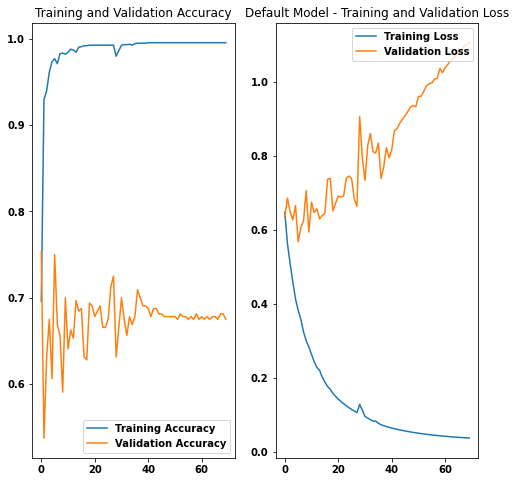

In [28]:
# Plotting Accuracy and loss for teh default model
acc = default_model_saved.history['accuracy']
val_acc = default_model_saved.history['val_accuracy']
loss = default_model_saved.history['loss']
val_loss = default_model_saved.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Default Model - Training and Validation Loss')
plt.show()

### 4. Evaluate the trained CNN model on test data. Print classification  results. [2 point]

In [29]:
df = pd.DataFrame(columns=['Actual', 'Predicted'])
images = []
rows_list = []
def predictimages(folder_path, mask_type, df):
  className = 'masked'
  if mask_type == False:
    className = 'unmasked'
  folder_path += '/' + className
  for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = keras.preprocessing.image.load_img(img, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = default_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    rows_list.append({'Actual': mask_type, 'Predicted' : mask_type if (class_names[np.argmax(score)] == className) else (not mask_type)})

folder_path = test_ds_path
mask_type = True
predictimages(folder_path, mask_type, df)
mask_type = False
predictimages(folder_path, mask_type, df)
df = pd.DataFrame(rows_list)

print('---------------------------Accuracy Score----------------')
print(accuracy_score(df['Actual'].tolist(),df['Predicted'].tolist()))
print('---------------------------Confusion Matrix----------------')
print(confusion_matrix(df['Actual'].tolist(),df['Predicted'].tolist()).ravel())
print('---------------------------Precision Recall Fscore Support----------------')
default_precision, default_recall, default_fscore, default_support = precision_recall_fscore_support(df['Actual'].tolist(),df['Predicted'].tolist(), average='macro')
print(default_precision, default_recall, default_fscore, default_support)
print('---------------------------Classification Report----------------')
print(classification_report(df['Actual'].tolist(),df['Predicted'].tolist()))

---------------------------Accuracy Score----------------
0.675
---------------------------Confusion Matrix----------------
[131  29  75  85]
---------------------------Precision Recall Fscore Support----------------
0.6907681825924034 0.675 0.6681424753699494 None
---------------------------Classification Report----------------
              precision    recall  f1-score   support

       False       0.64      0.82      0.72       160
        True       0.75      0.53      0.62       160

    accuracy                           0.68       320
   macro avg       0.69      0.68      0.67       320
weighted avg       0.69      0.68      0.67       320



In [30]:
#5  Adding more layers to improve the accuracy
improved_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='softmax'),
  layers.Dense(num_classes)
])

# Compile the model with adam optimizer with metrics as accuracy
improved_model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the CNN model for E epoch (take E=70), save the train_loss, train_acc, validation_loss, validation_acc for each epoch and plot it after training has finished. [4 points]
improved_model_saved = improved_model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/70
54/54 [==============================] - 8s 144ms/step - loss: 0.6567 - accuracy: 0.6840 - val_loss: 0.6395 - val_accuracy: 0.6687
Epoch 2/70
54/54 [==============================] - 8s 145ms/step - loss: 0.5151 - accuracy: 0.9206 - val_loss: 0.5909 - val_accuracy: 0.7375
Epoch 3/70
54/54 [==============================] - 8s 145ms/step - loss: 0.4624 - accuracy: 0.9373 - val_loss: 0.5769 - val_accuracy: 0.7500
Epoch 4/70
54/54 [==============================] - 8s 144ms/step - loss: 0.4877 - accuracy: 0.8616 - val_loss: 0.6313 - val_accuracy: 0.6625
Epoch 5/70
54/54 [==============================] - 8s 140ms/step - loss: 0.4018 - accuracy: 0.9474 - val_loss: 0.6015 - val_accuracy: 0.6906
Epoch 6/70
54/54 [==============================] - 8s 141ms/step - loss: 0.3585 - accuracy: 0.9635 - val_loss: 0.6541 - val_accuracy: 0.6438
Epoch 7/70
54/54 [==============================] - 8s 139ms/step - loss: 0.3407 - accuracy: 0.9605 - val_loss: 0.6923 - val_accuracy: 0.6000
Epoch 

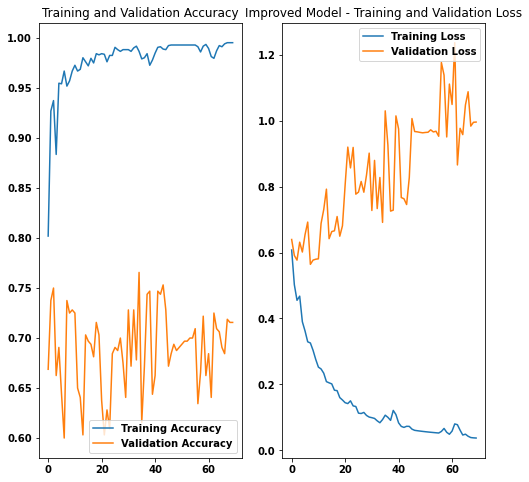

In [31]:
# Plotting Accuracy and loss for teh improved model
acc = improved_model_saved.history['accuracy']
val_acc = improved_model_saved.history['val_accuracy']
loss = improved_model_saved.history['loss']
val_loss = improved_model_saved.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Improved Model - Training and Validation Loss')
plt.show()    

In [32]:
# Evaluate the trained CNN model on test data. Print classification results. [2 point]
df = pd.DataFrame(columns=['Actual', 'Predicted'])
images = []
rows_list = []
def predictimages(folder_path, mask_type, df):
  className = 'masked'
  if mask_type == False:
    className = 'unmasked'
  folder_path += '/' + className
  for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    img = keras.preprocessing.image.load_img(img, target_size=(img_height, img_width))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = improved_model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    rows_list.append({'Actual': mask_type, 'Predicted' : mask_type if (class_names[np.argmax(score)] == className) else (not mask_type)})

folder_path = test_ds_path
mask_type = True
predictimages(folder_path, mask_type, df)
mask_type = False
predictimages(folder_path, mask_type, df)
df = pd.DataFrame(rows_list)

print('---------------------------Accuracy Score----------------')
print(accuracy_score(df['Actual'].tolist(),df['Predicted'].tolist()))
print('---------------------------Confusion Matrix----------------')
print(confusion_matrix(df['Actual'].tolist(),df['Predicted'].tolist()).ravel())
print('---------------------------Precision Recall Fscore Support----------------')
imporived_precision, imporived_recall, imporived_fscore, imporived_support = precision_recall_fscore_support(df['Actual'].tolist(),df['Predicted'].tolist(), average='macro')
print(imporived_precision, imporived_recall, imporived_fscore, imporived_support)
print('---------------------------Classification Report----------------')
print(classification_report(df['Actual'].tolist(),df['Predicted'].tolist()))

---------------------------Accuracy Score----------------
0.71875
---------------------------Confusion Matrix----------------
[142  18  72  88]
---------------------------Precision Recall Fscore Support----------------
0.746870040557221 0.71875 0.7105062120541996 None
---------------------------Classification Report----------------
              precision    recall  f1-score   support

       False       0.66      0.89      0.76       160
        True       0.83      0.55      0.66       160

    accuracy                           0.72       320
   macro avg       0.75      0.72      0.71       320
weighted avg       0.75      0.72      0.71       320



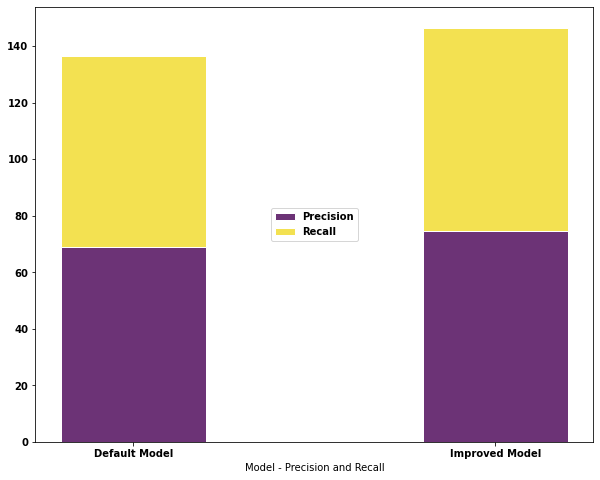

In [33]:
# Plot precision and recall for default and improved model in a single bar plot
fig, ax = plt.subplots(figsize=(10,8))
rc('font', weight='bold')
bars1 = np.array([default_precision, imporived_precision])*100
bars2 = np.array([default_recall, imporived_recall])*100
bars = np.add(bars1, bars2).tolist()
r = [0,1]
names = ['Default Model','Improved Model']
barWidth = 0.4
plt.bar(r, bars1, color='#6c3376', edgecolor='white', width=barWidth, label="Precision")
plt.bar(r, bars2, bottom=bars1, color='#f3e151', edgecolor='white', width=barWidth, label="Recall")
plt.xticks(r, names, fontweight='bold')
plt.xlabel("Model - Precision and Recall")
plt.legend(loc="center")
plt.show()

In [34]:
print('\nDefault Model Precision :' + str(default_precision))
print('\nImproved Model Precision : ' + str(imporived_precision))
print('--------------------------------------------------------')
print('\nDefault Model Recall :' + str(default_recall))
print('\nImproved Model Recall : ' + str(imporived_recall))


Default Model Precision :0.6907681825924034

Improved Model Precision : 0.746870040557221
--------------------------------------------------------

Default Model Recall :0.675

Improved Model Recall : 0.71875


## End Of Assignment